In [2]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [3]:
torch.__version__

'1.11.0'

In [11]:
# not sure about the normalization, transforms.Normalize((0,), (1.0,))
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))]) 

In [12]:
Mnist_train = torchvision.datasets.MNIST('./Minist_data', train=True, download=True, transform=trans)
Mnist_test = torchvision.datasets.MNIST('./Minist_data', train=False, transform=trans)

In [34]:
batch_size = 32
random_seed = 42
lr = 1e-3
decay = 0.8
epoch = 20

In [19]:
torch.manual_seed(random_seed)
dataloader_train = DataLoader(Mnist_train, batch_size = batch_size, shuffle  = True)
dataloader_test = DataLoader(Mnist_test, batch_size = batch_size, shuffle  = True)

### NN structure
$$\hat{y} = f(x) = g(W_2\sigma(W_1x))$$
Suppose $x \in \mathbb{R}^d$, $W_1 \in \mathbb{R}^{d_1 \times d}$, and $W_2 \in \mathbb{R}^{k \times d_1}$ i.e. $f: \mathbb{R}^d \rightarrow \mathbb{R}^k$, Let $\sigma(z) = [\sigma(z_1), ..., \sigma(z_n)]$ for any $z \in \mathbb{R}^n$ where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid (logistic) activation function and $g(z_i) = \frac{exp(z_i)}{\sum_{i=1}^k exp(z_i)}$ is the softmax function. 

### Gradient for weights
$$\frac{\partial L}{\partial W_2^{(i,j)}} = \sum_{z_w} \frac{\partial L}{\partial z_w}\frac{\partial z_w}{\partial W_2^{(i,j)}} = (\hat y_i - y_i)h_j$$

$$\frac{\partial L}{\partial W_1^{(i,j)}}= \sum_{w=1}^k \frac{\partial L}{\partial z_w} \sum_{h_m}\frac{\partial z_w} {\partial h_m} \frac{\partial h_m}{\partial W_1^{(i,j)}} = h_i(1-h_i)x_j\sum_{w=1}^{k} W_2^{(w, i)} (\hat y_w - y_w)$$

In [ ]:
#hand-craft NN
#initial weights
d_1 = 300
d_2 = 200
W_1 = torch.rand(d_1, 784)*2-1 #torch.zeros(d_1, 784)
W_2 = torch.rand(10, d_1)*2-1 #torch.zeros(10, d_1)
train_acc = []
test_acc = []
train_losses = []
test_losses = []

In [46]:
for e in range(epoch):
    correct_train = 0
    count_train = 0
    loss_train = 0
    #training
    for batch_idx, (x, target) in enumerate(dataloader_train):
        #forward
        this_batch_size = x.shape[0]
        x_flatten = torch.reshape(x, (this_batch_size, 28*28, 1))
        out_1 = torch.matmul(W_1, x_flatten)
        act_1 = torch.sigmoid(out_1)
        out_2 = torch.matmul(W_2, act_1)
        m = torch.nn.Softmax(dim = 1)
        y_pred = m(out_2)

        #backward
        #one hot
        y_true = torch.nn.functional.one_hot(target, num_classes=10).view((this_batch_size, 10, 1))
        y_pred_labels = torch.argmax(y_pred, dim = 1)
        grad_W_2 = torch.mul(y_pred-y_true, act_1.view((this_batch_size, 1, d_1))) #use broadcasting to get the correct size
        temp_1 = torch.sum(torch.mul(y_pred-y_true, W_2), 1).view((this_batch_size, d_1, 1)) 
        #broadcasting the mul result in same size as w_2, sum in dim 1 (sum each col)
        temp_2 = torch.mul(act_1, torch.ones_like(act_1)-act_1)
        grad_W_1 = torch.mul(torch.mul(temp_2, x.view((this_batch_size, 1, 28*28))), temp_1)
        
        #learning
        W_1 = W_1 - lr*torch.mean(grad_W_1, 0)
        W_2 = W_2 - lr*torch.mean(grad_W_2, 0)
        correct_train = correct_train + torch.sum(y_pred_labels.flatten()==target)
        count_train = count_train + this_batch_size
        loss_train = loss_train-torch.sum(torch.mul(y_true.flatten(), torch.log(y_pred.flatten())))
        # print(y_pred)
    train_acc.append(correct_train/count_train)
    train_losses.append(loss_train/count_train)
    #testing
    correct_test = 0
    count_test = 0
    loss_test = 0
    for batch_idx, (x, target) in enumerate(dataloader_test):
        #forward
        this_batch_size = x.shape[0]
        x_flatten = torch.reshape(x, (this_batch_size, 28*28, 1))
        out_1 = torch.matmul(W_1, x_flatten)
        act_1 = torch.sigmoid(out_1)
        out_2 = torch.matmul(W_2, act_1)
        m = torch.nn.Softmax(dim = 1)
        y_pred = m(out_2)
        y_true = torch.nn.functional.one_hot(target, num_classes=10).view((this_batch_size, 10, 1))
        y_pred_labels = torch.argmax(y_pred, dim = 1)
        correct_test = correct_test + torch.sum(y_pred_labels.flatten()==target)
        count_test = count_test + this_batch_size
        loss_test = loss_test-torch.sum(torch.mul(y_true.flatten(), torch.log(y_pred.flatten())))
    test_acc.append(correct_test/count_test)
    test_losses.append(loss_test/count_test)
    # print(W_1)
    print('epoch: %d, acc_train: %f, acc_test: %f, train_loss: %f, test_loss: %f'%(e, train_acc[-1], test_acc[-1], train_losses[-1], test_losses[-1]))

epoch: 0, acc_train: 0.819500, acc_test: 0.830500, train_loss: 0.588119, test_loss: 0.555129
epoch: 1, acc_train: 0.823100, acc_test: 0.833100, train_loss: 0.577193, test_loss: 0.546137
epoch: 2, acc_train: 0.826250, acc_test: 0.834900, train_loss: 0.567271, test_loss: 0.536897
epoch: 3, acc_train: 0.829350, acc_test: 0.836800, train_loss: 0.557882, test_loss: 0.529092
epoch: 4, acc_train: 0.831483, acc_test: 0.840200, train_loss: 0.549100, test_loss: 0.521078
epoch: 5, acc_train: 0.834083, acc_test: 0.842100, train_loss: 0.540958, test_loss: 0.513643
epoch: 6, acc_train: 0.837417, acc_test: 0.843600, train_loss: 0.533184, test_loss: 0.506944
epoch: 7, acc_train: 0.839117, acc_test: 0.846500, train_loss: 0.525859, test_loss: 0.500670
epoch: 8, acc_train: 0.841467, acc_test: 0.847200, train_loss: 0.518988, test_loss: 0.494250
epoch: 9, acc_train: 0.843617, acc_test: 0.849500, train_loss: 0.512269, test_loss: 0.488732
epoch: 10, acc_train: 0.845100, acc_test: 0.850800, train_loss: 0.5060

In [ ]:
'''
epoch: 0, acc_train: 0.223950, acc_test: 0.344900, train_loss: 3.741858, test_loss: 2.595963
epoch: 1, acc_train: 0.416333, acc_test: 0.493900, train_loss: 2.190548, test_loss: 1.799082
epoch: 2, acc_train: 0.529150, acc_test: 0.579400, train_loss: 1.646924, test_loss: 1.415318
epoch: 3, acc_train: 0.597400, acc_test: 0.638300, train_loss: 1.358475, test_loss: 1.197625
epoch: 4, acc_train: 0.643933, acc_test: 0.677600, train_loss: 1.181378, test_loss: 1.056924
epoch: 5, acc_train: 0.676667, acc_test: 0.702300, train_loss: 1.061621, test_loss: 0.959975
epoch: 6, acc_train: 0.701783, acc_test: 0.725800, train_loss: 0.974901, test_loss: 0.887966
epoch: 7, acc_train: 0.721233, acc_test: 0.742500, train_loss: 0.908449, test_loss: 0.832959
epoch: 8, acc_train: 0.736550, acc_test: 0.758800, train_loss: 0.855966, test_loss: 0.787457
epoch: 9, acc_train: 0.749233, acc_test: 0.770600, train_loss: 0.812977, test_loss: 0.751445
epoch: 10, acc_train: 0.760533, acc_test: 0.779300, train_loss: 0.777040, test_loss: 0.720001
epoch: 11, acc_train: 0.769167, acc_test: 0.788700, train_loss: 0.746451, test_loss: 0.693666
epoch: 12, acc_train: 0.777650, acc_test: 0.795200, train_loss: 0.719921, test_loss: 0.670713
epoch: 13, acc_train: 0.785783, acc_test: 0.802600, train_loss: 0.696647, test_loss: 0.650781
epoch: 14, acc_train: 0.791800, acc_test: 0.808800, train_loss: 0.676171, test_loss: 0.632407
epoch: 15, acc_train: 0.797467, acc_test: 0.812800, train_loss: 0.657676, test_loss: 0.616492
epoch: 16, acc_train: 0.802233, acc_test: 0.817600, train_loss: 0.641133, test_loss: 0.602079
epoch: 17, acc_train: 0.807600, acc_test: 0.821100, train_loss: 0.626101, test_loss: 0.588513
epoch: 18, acc_train: 0.811683, acc_test: 0.824100, train_loss: 0.612218, test_loss: 0.576511
epoch: 19, acc_train: 0.815833, acc_test: 0.826800, train_loss: 0.599666, test_loss: 0.565604
'''

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
df_stats = pd.DataFrame({'acc_train':[float(i) for i in train_acc], 'acc_test':[float(i) for i in test_acc], 'train_loss':[float(i) for i in train_losses],  'test_loss':[float(i) for i in test_losses]})
# df_stats

In [74]:
df_stats.to_csv('data_self.csv')

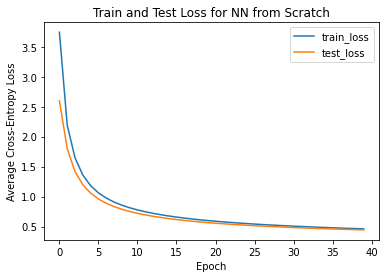

In [78]:
ax = df_stats.plot.line(y = ['train_loss', 'test_loss'])
ax.set_title('Train and Test Loss for NN from Scratch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Cross-Entropy Loss')
plt.savefig('nn_scratch_loss.pdf')

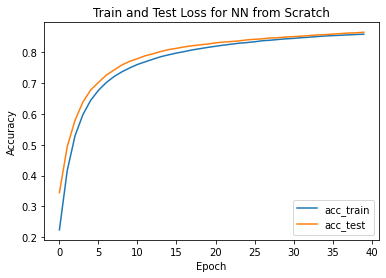

In [77]:
ax = df_stats.plot.line(y = ['acc_train', 'acc_test'])
ax.set_title('Train and Test Loss for NN from Scratch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.savefig('nn_scratch_acc.pdf')

In [126]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 300)
        self.ac1 = nn.Sigmoid()
        self.fc2 = nn.Linear(300, 10)
        self.sm = nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.ac1(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [151]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [142]:
log_interval=500
def train(epoch):
  train_losses = []
  network.train()
  for batch_idx, (data, target) in enumerate(dataloader_train):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      # print(output)
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(dataloader_train.dataset),
        100. * batch_idx / len(dataloader_train), loss.item()))
    train_losses.append(loss.item())
  return sum(train_losses)/len(train_losses)

In [143]:
def test():
  network.eval()
  test_losses = []
  correct = 0
  with torch.no_grad():
    for data, target in dataloader_test:
      output = network(data)
      test_losses.append(F.nll_loss(output, target).item())
      y_pred_labels = torch.argmax(output, dim = 1)
      correct = correct + torch.sum(y_pred_labels.flatten()==target)
      pred = output.data.max(1, keepdim=True)[1]
      # correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss = sum(test_losses)/len(test_losses)
  # test_losses.append(test_loss)
  # print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  #   test_loss, correct, len(test_loader.dataset),
  #   100. * correct / len(test_loader.dataset)))
  return test_loss, float(correct / len(dataloader_test.dataset))

In [152]:
torch_NN_train_losses = []
torch_NN_test_losses = []
torch_NN_test_acc = []
# torch.nn.init.uniform_(network.fc1.weight, -1, 1)
# torch.nn.init.uniform_(network.fc2.weight, -1, 1)
torch.nn.init.constant_(network.fc1.weight, 0)
torch.nn.init.constant_(network.fc2.weight, 0)
for i in range(40):
    train_loss = train(i)
    test_loss, test_acc = test()
    torch_NN_train_losses.append(train_loss)
    torch_NN_test_losses.append(test_loss)
    torch_NN_test_acc.append(test_acc)
    print(torch_NN_train_losses[-1], torch_NN_test_losses[-1], torch_NN_test_acc[-1])

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306086
Train Epoch: 0 [16000/60000 (27%)]	Loss: 2.302017
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.288103
Train Epoch: 0 [48000/60000 (80%)]	Loss: 2.300159
2.3019012082417807 2.3011100634980126 0.11349999904632568
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306396
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.294797
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.311606
Train Epoch: 1 [48000/60000 (80%)]	Loss: 2.296768
2.301751165644328 2.3013483891471886 0.11349999904632568
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.306611
Train Epoch: 2 [16000/60000 (27%)]	Loss: 2.300690
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.299802
Train Epoch: 2 [48000/60000 (80%)]	Loss: 2.293395
2.3017377922058104 2.3011013349405114 0.11349999904632568
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.306188
Train Epoch: 3 [16000/60000 (27%)]	Loss: 2.298433
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.292217
Train Epoch: 3 [48000/60000 (80%)]	Loss: 2.289935
2.3017586076100667 2.301386191060368 0.11349999

In [153]:
NN_torch_data = pd.DataFrame({'train_loss': torch_NN_train_losses, 'test_loss': torch_NN_test_losses, 'test_acc' : torch_NN_test_acc})
NN_torch_data.to_csv('data_torch_zero_init.csv')

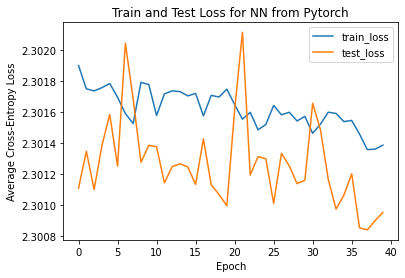

In [154]:
ax = NN_torch_data.plot.line(y = ['train_loss', 'test_loss'])
ax.set_title('Train and Test Loss for NN from Pytorch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Cross-Entropy Loss')
plt.savefig('nn_torch_loss_zero_init.pdf')

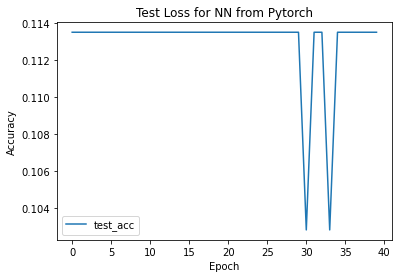

In [155]:
ax = NN_torch_data.plot.line(y = ['test_acc'])
ax.set_title('Test Loss for NN from Pytorch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.savefig('nn_torch_acc_zero_init.pdf')

In [158]:
df = pd.read_csv('data_torch_rand_init.csv')
df

,Unnamed: 0,train_loss,test_loss,test_acc
0,0,3.488438,2.508241,0.3322
1,1,2.123821,1.776475,0.4824
2,2,1.611253,1.426605,0.5733
3,3,1.342759,1.220992,0.6279
4,4,1.178048,1.085381,0.6681
5,5,1.065282,0.990721,0.6968
6,6,0.982598,0.917469,0.7221
7,7,0.918492,0.862133,0.7397
8,8,0.867165,0.814980,0.7508
9,9,0.824962,0.777188,0.7652
